Copyright **`(c)`** 2023 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

# LAB9

Write a local-search algorithm (eg. an EA) able to solve the *Problem* instances 1, 2, 5, and 10 on a 1000-loci genomes, using a minimum number of fitness calls. That's all.

### Deadlines:

* Submission: Sunday, December 3 ([CET](https://www.timeanddate.com/time/zones/cet))
* Reviews: Sunday, December 10 ([CET](https://www.timeanddate.com/time/zones/cet))

Notes:

* Reviews will be assigned  on Monday, December 4
* You need to commit in order to be selected as a reviewer (ie. better to commit an empty work than not to commit)

In [191]:
from random import random, choice, randint,sample,choices
from functools import reduce
from collections import namedtuple
from dataclasses import dataclass
from copy import copy

from pprint import pprint

import numpy as np
import lab9_lib
import matplotlib.pyplot as plt

In [192]:
@dataclass
class Individual:
  def __init__(self,genotype: list[int], fitness:float=None):
        self.fitness = fitness
        self.genotype = np.array(genotype)
  def modify_fitness(self,fitness):
      self.fitness=fitness
 

# Class Population
The class population has:
- genotype that is bidimensional np.array containing the bitstrings of population
- fitness instead contains the fitness tuples corresponding to each genotype

In [193]:
@dataclass
class Population:
    def __init__(self,n,geno_length=1000):
     self.genotype=np.random.randint(2, size=(n, geno_length))
     self.fitness= tuple(lab9_lib.make_problem(n)(self.genotype[i]) for i in range(n))
     self.n=n
    def add_element(self,offsprings:list[Individual]):
       for i in offsprings:
        self.genotype=np.vstack([self.genotype,i.genotype])
        self.fitness=self.fitness+(i.fitness,)
        self.n+=1
       return
    def get_top_n_elements(self, N):
        sorted_indices = np.argsort(self.fitness)[::-1]  
        sorted_genotype = self.genotype[sorted_indices]
        sorted_fitness = np.array(self.fitness)[sorted_indices]
        return sorted_genotype[:N], sorted_fitness[:N]
    def get_best_element(self):
        index_of_best = np.argmax(self.fitness)
        best_genotype = self.genotype[index_of_best]
        best_fitness = self.fitness[index_of_best]

        return best_fitness,best_genotype
    def remove_worst_elements(self, j):
        sorted_indices = np.argsort(self.fitness)[::-1]  
        self.fitness = tuple(np.array(self.fitness)[sorted_indices[:j]])
        self.genotype = self.genotype[sorted_indices[:j]]
        self.n=j

In [194]:
def select_parent(pop:Population,TOURNAMENT_SIZE):
    pool = [randint(0,pop.n-1) for _ in range (TOURNAMENT_SIZE)]
    index_of_best = max(pool, key=lambda i: pop.fitness[i])
    best_genotype = pop.genotype[index_of_best]
    best_fitness = pop.fitness[index_of_best]

    return  best_fitness, best_genotype


# Mutation Crossover
Here i've implemented a mutation and 3 types of crossover

In [195]:
def mutate(ind: Individual,geno_length=1000) -> Individual:
    offspring = copy(ind)
    pos = randint(0, geno_length-1)
    offspring.genotype[pos] = not offspring.genotype[pos]
    offspring.fitness = None
    return offspring

def one_cut_xover(ind1: Individual, ind2: Individual,geno_length=1000) -> Individual:
    cut_point = randint(0, geno_length-1)
    offspring = Individual(fitness=None,
                           genotype=np.concatenate((ind1.genotype[cut_point:],ind2.genotype[:cut_point]),axis=0))
    return offspring
def two_point_crossover(ind1: Individual, ind2: Individual,geno_length=1000):
    crossover_points = sorted(sample(range(geno_length), 2))
    offspring = Individual(fitness=None,genotype=np.concatenate((ind1.genotype[:crossover_points[0]], ind2.genotype[crossover_points[0]:crossover_points[1]], ind1.genotype[crossover_points[1]:])))
    return offspring
def uniform_crossover(ind1: Individual, ind2: Individual,geno_length=1000):
    mask = np.random.randint(2, size=geno_length, dtype=bool)
    offspring = Individual(fitness=None,genotype=np.where(mask, ind1.genotype, ind2.genotype))
    return offspring

def random_crossover(ind1: Individual, ind2: Individual,geno_length=1000):
    crossover_functions = [one_cut_xover, two_point_crossover, uniform_crossover]
    selected_crossover_function = choice(crossover_functions)

    return selected_crossover_function(ind1,ind2,geno_length)

# Find Best Fitness
This function is used to generate a problem using lab9_lib and find best solution 

In [202]:
def find_best_fitness(POPULATION_SIZE = 100,makeproblem_size=10,OFFSPRING_SIZE=20,TOURNAMENT_SIZE=2,MUTATION_PROBABILITY=0.50,GENO_LENGTH=1000,early_stopping=1000):
    fitness_ = lab9_lib.make_problem(makeproblem_size)
    population=Population(POPULATION_SIZE,GENO_LENGTH)
    contatore_fitness=POPULATION_SIZE
    counter_early_stopping=0
    last_solution=None
    last_fit=0.
    array_fitness=[]
    cnt=[]
    while counter_early_stopping<=early_stopping:
        offspring = list()
        
        for counter in range(OFFSPRING_SIZE):
            if random() < MUTATION_PROBABILITY:  # self-adapt mutation probability
                # mutation  # add more clever mutations
                fitness,genotype = select_parent(population,TOURNAMENT_SIZE)
                p=Individual(fitness=fitness,genotype=genotype)
                o = mutate(p,GENO_LENGTH)
            else:
                # xover # add more xovers
                fitness,genotype = select_parent(population,TOURNAMENT_SIZE)
                p1=Individual(fitness=fitness,genotype=genotype)
                fitness,genotype = select_parent(population,TOURNAMENT_SIZE)
                p2 = Individual(fitness=fitness,genotype=genotype)
                o=random_crossover(p1, p2,GENO_LENGTH)
            
            offspring.append(o)

        for i in offspring:
            i.modify_fitness(fitness_(i.genotype))
            contatore_fitness+=1
        population.add_element(offspring)
        population.remove_worst_elements(POPULATION_SIZE)
        current_best_fit,current_best=population.get_best_element()
        array_fitness.append(current_best_fit)
        cnt.append(len(array_fitness))
        if(abs((current_best_fit-last_fit))<0.001):
            counter_early_stopping+=1    
        else:

             counter_early_stopping=0

        last_fit=current_best_fit
        
    best_fitness,el=population.get_best_element()  
      
    if(early_stopping!=None):
        print("Using early stopping at ",early_stopping," i've used the fitness :",contatore_fitness,"time and i obtained a fitness of: ", best_fitness)
    else:
        print("without early stopping i've used the fitness :",contatore_fitness,"time and i obtained a fitness of: ",best_fitness)
    # Plot dei risultati

    last_2_percent = int(len(array_fitness) * (1 - 0.98))

    plt.plot(cnt[last_2_percent:], array_fitness[last_2_percent:], marker='.')

    plt.xlabel('Fitness call')
    plt.ylabel('Fitness value')
    plt.title('Plot of fitness value for each fitness call')

    # Mostra il plot
    plt.show()

Using early stopping at  1000  i've used the fitness : 21160 time and i obtained a fitness of:  0.327667


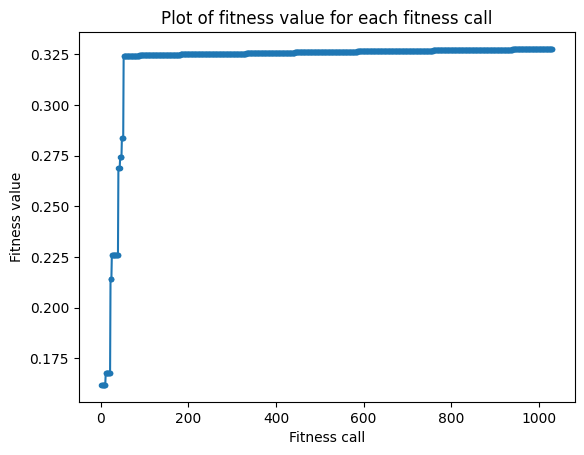

In [203]:
find_best_fitness()
#find_best_fitness(early_stopping=75)

In [ ]:
arr=[1,2,3,4,5,6,7,8,9,10]
print(arr[-2:])

[9, 10]
